In [25]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Flight Report Preprocessing

In [26]:
df_merged = pd.DataFrame()

for file in range(1, 10):
    df_cur = pd.read_csv('raw_data_unzipped/ONTIME_REPORTING_0' + str(file) + '.csv')
    df_merged = pd.concat([df_merged, df_cur])

df10 = pd.read_csv('raw_data_unzipped/ONTIME_REPORTING_10.csv')
df11 = pd.read_csv('raw_data_unzipped/ONTIME_REPORTING_11.csv')
df12 = pd.read_csv('raw_data_unzipped/ONTIME_REPORTING_12.csv')

flight_report = pd.concat([df_merged, df10, df11, df12])


In [27]:
flight_report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7422037 entries, 0 to 625762
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY_OF_MONTH         int64  
 2   DAY_OF_WEEK          int64  
 3   OP_UNIQUE_CARRIER    object 
 4   TAIL_NUM             object 
 5   OP_CARRIER_FL_NUM    int64  
 6   ORIGIN_AIRPORT_ID    int64  
 7   ORIGIN               object 
 8   ORIGIN_CITY_NAME     object 
 9   DEST_AIRPORT_ID      int64  
 10  DEST                 object 
 11  DEST_CITY_NAME       object 
 12  CRS_DEP_TIME         int64  
 13  DEP_TIME             float64
 14  DEP_DELAY_NEW        float64
 15  DEP_DEL15            float64
 16  DEP_TIME_BLK         object 
 17  CRS_ARR_TIME         int64  
 18  ARR_TIME             float64
 19  ARR_DELAY_NEW        float64
 20  ARR_TIME_BLK         object 
 21  CANCELLED            float64
 22  CANCELLATION_CODE    object 
 23  CRS_ELAPSED_TIME     float64
 24  ACTU

In [28]:
flight_report.shape

(7422037, 33)

In [29]:
# dropping where the flight was cancelled, the departure time is NA, OR the tail number is NA
flight_report.drop(flight_report.loc[(flight_report['CANCELLED']==1) |
                                     (flight_report['DEP_TIME'].isna()) |
                                     (flight_report['TAIL_NUM'].isna())].index, axis=0, inplace=True)

In [30]:
flight_report

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,...,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,...,47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,...,47.0,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,1,9,3,9E,N840AY,3280,10397,ATL,"Atlanta, GA",11150,...,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,1,10,4,9E,N8969A,3280,10397,ATL,"Atlanta, GA",11150,...,47.0,41.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625757,12,31,2,B6,N348JB,845,10721,BOS,"Boston, MA",15096,...,77.0,60.0,265.0,2,NaN,NaN,NaN,NaN,NaN,NaN
625758,12,31,2,B6,N193JB,846,13204,MCO,"Orlando, FL",15070,...,163.0,151.0,989.0,4,52.0,0.0,0.0,0.0,0.0,NaN
625759,12,31,2,B6,N304JB,854,11278,DCA,"Washington, DC",10721,...,90.0,79.0,399.0,2,NaN,NaN,NaN,NaN,NaN,NaN
625760,12,31,2,B6,N193JB,860,14100,PHL,"Philadelphia, PA",10721,...,85.0,59.0,280.0,2,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
carrier_names = pd.read_csv('raw_data_unzipped/CARRIER_DECODE.csv')

In [32]:
carrier_names.drop_duplicates(inplace=True)
carrier_names.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
carrier_names

,AIRLINE_ID,OP_UNIQUE_CARRIER,CARRIER_NAME
0,21754,2PQ,21 Air LLC
3,20342,Q5,40-Mile Air
4,20342,WRB,40-Mile Air
6,19627,CIQ,A/S Conair
7,19072,AAE,AAA Airlines
...,...,...,...
2702,20379,ZKQ,Zantop International
2706,19771,ZAQ,Zas Airline Of Egypt
2707,21118,37,Zeal 320
2708,22069,ZG,ZIPAIR Tokyo Inc.


In [33]:
flight_report = pd.merge(flight_report, carrier_names, how='left', on=['OP_UNIQUE_CARRIER'])

### Distribution of Airline Carriers in the Data

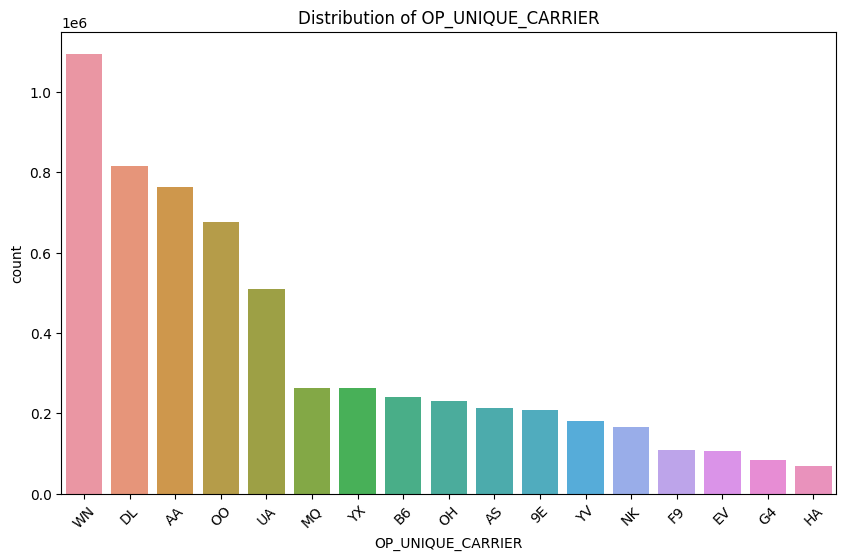

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=flight_report, x="OP_UNIQUE_CARRIER", order=flight_report["OP_UNIQUE_CARRIER"].value_counts().index)
plt.title(f'Distribution of OP_UNIQUE_CARRIER')
plt.xticks(rotation=45)
plt.show()

### Departure Delays by Carrier

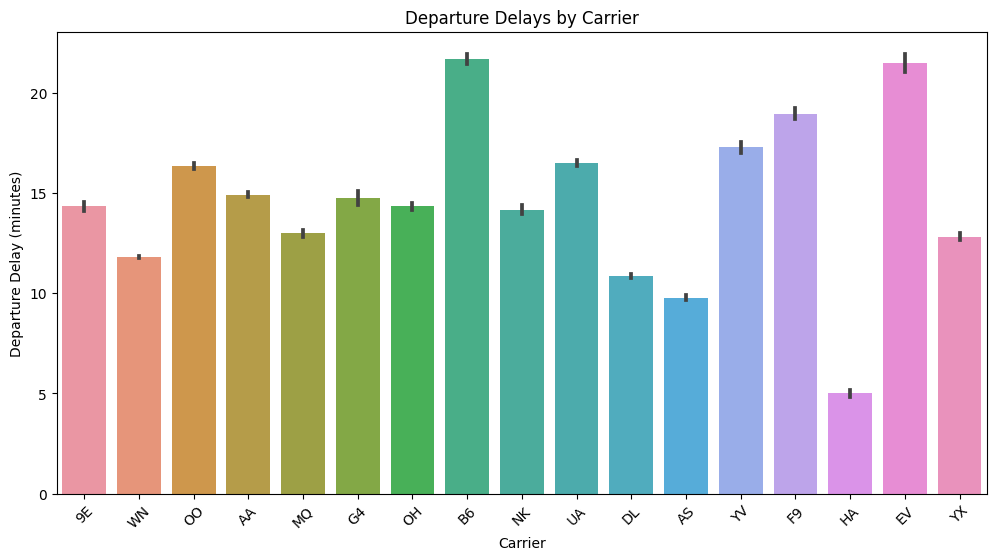

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(data=flight_report, x="OP_UNIQUE_CARRIER", y="DEP_DELAY_NEW")
plt.title("Departure Delays by Carrier")
plt.xticks(rotation=45)
plt.xlabel("Carrier")
plt.ylabel("Departure Delay (minutes)")
plt.show()

## Weather Report Preprocessing

In [36]:
weather2019 = pd.read_csv('raw_data_unzipped/airport_weather_2019.csv')

In [37]:
airport_cities = pd.read_csv('raw_data_unzipped/airports_list.csv')
airport_cities

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
...,...,...,...,...
92,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
93,12264,Washington Dulles International,"Washington, DC","WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US"
94,13851,Will Rogers World,"Oklahoma City, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,12191,William P Hobby,"Houston, TX","HOUSTON WILLIAM P HOBBY AIRPORT, TX US"


In [38]:
weather_merged = pd.merge(airport_cities, weather2019, how='left', on='NAME')

In [39]:
weather_report = weather_merged[['NAME', 'DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'ORIGIN_AIRPORT_ID']]
weather_report.rename(columns={'NAME': 'AIRPORT_NAME'}, inplace=True)
weather_report

,AIRPORT_NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,ORIGIN_AIRPORT_ID
0,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-01,4.70,0.00,0.0,0.0,45.0,12992
1,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-02,2.01,0.39,0.0,0.0,39.0,12992
2,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-03,6.26,0.44,0.0,0.0,41.0,12992
3,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-04,2.01,0.13,0.0,0.0,47.0,12992
4,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-05,1.79,0.00,0.0,0.0,62.0,12992
...,...,...,...,...,...,...,...,...
35020,"BOISE AIR TERMINAL, ID US",2019-12-27,5.82,0.00,0.0,0.0,35.0,10713
35021,"BOISE AIR TERMINAL, ID US",2019-12-28,2.24,0.00,0.0,0.0,39.0,10713
35022,"BOISE AIR TERMINAL, ID US",2019-12-29,6.26,0.04,0.1,0.0,32.0,10713
35023,"BOISE AIR TERMINAL, ID US",2019-12-30,2.46,0.00,0.0,0.0,34.0,10713


In [40]:
weather_report.isna().sum()

AIRPORT_NAME             0
DATE                     1
AWND                     9
PRCP                    22
SNOW                 11060
SNWD                 11565
TMAX                     6
ORIGIN_AIRPORT_ID        0
dtype: int64

#### Dealing with nulls

In [41]:
weather_report.drop(weather_report.loc[weather_report['DATE'].isna()].index, axis=0, inplace=True)
weather_report.fillna(0, inplace=True)
weather_report.isna().sum()

AIRPORT_NAME         0
DATE                 0
AWND                 0
PRCP                 0
SNOW                 0
SNWD                 0
TMAX                 0
ORIGIN_AIRPORT_ID    0
dtype: int64

#### Creating datetime object to merge with flight report dataset

In [42]:
weather_report['DATE'] = pd.to_datetime(weather_report['DATE'], errors='coerce')
weather_report['MONTH'] = pd.DatetimeIndex(weather_report['DATE']).month
weather_report['DAY_OF_MONTH'] = pd.DatetimeIndex(weather_report['DATE']).day
weather_report

,AIRPORT_NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,ORIGIN_AIRPORT_ID,MONTH,DAY_OF_MONTH
0,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-01,4.70,0.00,0.0,0.0,45.0,12992,1.0,1.0
1,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-02,2.01,0.39,0.0,0.0,39.0,12992,1.0,2.0
2,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-03,6.26,0.44,0.0,0.0,41.0,12992,1.0,3.0
3,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-04,2.01,0.13,0.0,0.0,47.0,12992,1.0,4.0
4,"NORTH LITTLE ROCK AIRPORT, AR US",2019-01-05,1.79,0.00,0.0,0.0,62.0,12992,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
35020,"BOISE AIR TERMINAL, ID US",2019-12-27,5.82,0.00,0.0,0.0,35.0,10713,12.0,27.0
35021,"BOISE AIR TERMINAL, ID US",2019-12-28,2.24,0.00,0.0,0.0,39.0,10713,12.0,28.0
35022,"BOISE AIR TERMINAL, ID US",2019-12-29,6.26,0.04,0.1,0.0,32.0,10713,12.0,29.0
35023,"BOISE AIR TERMINAL, ID US",2019-12-30,2.46,0.00,0.0,0.0,34.0,10713,12.0,30.0


## Merge Flight and Weather

In [43]:
flight_report = pd.merge(flight_report, weather_report, how='inner', on=['ORIGIN_AIRPORT_ID', 'MONTH', 'DAY_OF_MONTH'])

In [44]:
flight_report.to_csv("flight_report_merged.csv", index=False)